# 05 Logistic Regression Part 2

## Introduction

In this notebook, we will use logistic regression to predict which passengers survived in the Titanic data set. In particular, there are 3 major topics of discussion:

1) How should we handle the NULL values in each column?
2) How do we use categorical variables in Pyspark's MLlib library?
3) How do we leverage `Pipeline` objects to package our feature transformations and model training into a single object?

Note that there are 2 different directions we could take this model:

* **Inference:** We could build a model that makes statements about the relationships between passenger attributes vs probability of survival. In this case, our ultimate goal would be to answer the following questions: "Does attribute X increase or decrease the probability of survival? How confident are we in this statement?" 

* **Prediction:** Alternatively, we could build a model for pure prediction. In this case, our ultimate goal would be to maximize either accuracy, F1-score, or AUC on some holdout data set.

For this specific data set, a model for inference seems more valuable than a model for prediction. After all, the sinking of the Titanic isn't a repeatable event, so uncovering insights would be more useful than a predictive model.

<br>

---

<br>

## 5.1 The Titanic Dataset

The Titanic data set contains a subset of the passengers aboard the HMS Titanic during its maiden voyage in 1912. The ship ultimately sank 4 days into its transatlantic journey; the data set contains attributes of each passenger as well as a column `Survived` indicating whether the passenger survived the sinking. Our goal is to train a logistic regression model that can generate a passenger's probability of survival based on the attributes of that passenger.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

DATA_PATH = "../course_materials/Spark_for_Machine_Learning/Logistic_Regression/"
spark = SparkSession.builder.appName("Logistic Regression 2").getOrCreate()

df = spark.read.csv(DATA_PATH + "titanic.csv", inferSchema = True, header = True)

In [12]:
print(f"Number of rows: {df.count()}")
df.printSchema()

df.show(5)

Number of rows: 891
root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|

In [45]:
# count NULL values in each column
for col in df.columns:
    nulls = df.filter(df[col].isNull()).count()
    print(f"{col}: {nulls}")

PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 177
SibSp: 0
Parch: 0
Ticket: 0
Fare: 0
Cabin: 687
Embarked: 2


The are 177 rows with a missing `Age` value.

## 5.2 EDA

In [57]:
df.agg(
    F.mean("Survived").alias("mean_survived"),
    F.mean("Pclass").alias("mean_class"),
    F.mean("Age").alias("mean_age"),
    F.mean("SibSp").alias("mean_siblings_spouses"),
    F.mean("Parch").alias("mean_parent_children"),
    F.mean("Fare").alias("mean_fare")
).show()

+------------------+-----------------+-----------------+---------------------+--------------------+----------------+
|     mean_survived|       mean_class|         mean_age|mean_siblings_spouses|mean_parent_children|       mean_fare|
+------------------+-----------------+-----------------+---------------------+--------------------+----------------+
|0.3838383838383838|2.308641975308642|29.69911764705882|   0.5230078563411896| 0.38159371492704824|32.2042079685746|
+------------------+-----------------+-----------------+---------------------+--------------------+----------------+



This summary view gives the average value of each numeric column. However, we are interested in the differences in attributes between survivors and non-survivors.

In [25]:
df.groupBy("Survived").agg(
    F.mean("Pclass").alias("mean_class"),
    F.mean("Age").alias("mean_age"),
    F.mean("SibSp").alias("mean_siblings_spouses"),
    F.mean("Parch").alias("mean_parent_children"),
    F.mean("Fare").alias("mean_fare")
).show()

+--------+------------------+------------------+---------------------+--------------------+------------------+
|Survived|        mean_class|          mean_age|mean_siblings_spouses|mean_parent_children|         mean_fare|
+--------+------------------+------------------+---------------------+--------------------+------------------+
|       1|1.9502923976608186|28.343689655172415|  0.47368421052631576|  0.4649122807017544| 48.39540760233917|
|       0|2.5318761384335153| 30.62617924528302|   0.5537340619307832|  0.3296903460837887|22.117886885245877|
+--------+------------------+------------------+---------------------+--------------------+------------------+



In [70]:
df.groupBy("Sex").agg(
    F.count("Sex").alias("count"),
    F.mean("Survived").alias("mean_survived"),
    F.mean("Pclass").alias("mean_class"),
    F.mean("Age").alias("mean_age"),
    F.mean("SibSp").alias("mean_siblings_spouses"),
    F.mean("Parch").alias("mean_parent_children"),
    F.mean("Fare").alias("mean_fare")
).show()

+------+-----+-------------------+-----------------+------------------+---------------------+--------------------+------------------+
|   Sex|count|      mean_survived|       mean_class|          mean_age|mean_siblings_spouses|mean_parent_children|         mean_fare|
+------+-----+-------------------+-----------------+------------------+---------------------+--------------------+------------------+
|female|  314| 0.7420382165605095|2.159235668789809|27.915708812260537|   0.6942675159235668|  0.6496815286624203| 44.47981783439487|
|  male|  577|0.18890814558058924|2.389948006932409| 30.72664459161148|  0.42980935875216636| 0.23570190641247835|25.523893414211418|
+------+-----+-------------------+-----------------+------------------+---------------------+--------------------+------------------+



Generally speaking:

* Survivors were slightly younger with a mean age of 28 as compared to non-survivors who had a mean age of 30. This could be evidence that children may have been given priority on the lifeboats
* Survivors generally had a higher Parent-Child count, indicating that small children and their parents were given priority for evacuation.
* Survivors generally came from 1st or 2nd class and paid a higher ticket price, which indicates that more affluent passengers were given preferential treatment.
* Female passengers were overwhelming more likely to survive than male passengers.

In [59]:
df.groupBy("Embarked").agg(
    F.count("Embarked").alias("count"),
    F.mean("Survived").alias("mean_survived"),
    F.mean("Pclass").alias("mean_class"),
    F.mean("Age").alias("mean_age"),
    F.mean("SibSp").alias("mean_siblings_spouses"),
    F.mean("Parch").alias("mean_parent_children"),
    F.mean("Fare").alias("mean_fare")
).show()

+--------+-----+-------------------+------------------+------------------+---------------------+--------------------+------------------+
|Embarked|count|      mean_survived|        mean_class|          mean_age|mean_siblings_spouses|mean_parent_children|         mean_fare|
+--------+-----+-------------------+------------------+------------------+---------------------+--------------------+------------------+
|       Q|   77|0.38961038961038963| 2.909090909090909|28.089285714285715|  0.42857142857142855| 0.16883116883116883|13.276029870129872|
|    NULL|    0|                1.0|               1.0|              50.0|                  0.0|                 0.0|              80.0|
|       C|  168| 0.5535714285714286|1.8869047619047619| 30.81476923076923|   0.3869047619047619|  0.3630952380952381| 59.95414404761905|
|       S|  644|0.33695652173913043|2.3509316770186337| 29.44539711191336|   0.5714285714285714| 0.41304347826086957| 27.07981180124218|
+--------+-----+-------------------+-----

In [67]:
df.groupBy(["Embarked"]).pivot("Sex").count().show()

+--------+------+----+
|Embarked|female|male|
+--------+------+----+
|       Q|    36|  41|
|    NULL|     2|NULL|
|       C|    73|  95|
|       S|   203| 441|
+--------+------+----+



Generally speaking:

* People who embarked at Queenstown (`Q`) had fewer children and younger age. This likely indicates they were mostly young adults. Queenstown passengers also paid a lower fare price and were most likely to be in 3rd class.
* People who embarked at Cherbourg (`C`) paid the highest fare price and were more likely to be in 1st and 2nd class. Consequently, they also have a much larger survival probability than the other 2 ports.
* People who embarked at Southampton (`S`) on average had the highest Parent/Child count and Sibling/Spouse count. These were likely large families traveling together. The male passengers also outnumber female passengers at 2:1 for Southhampton. This could explain why Southhampton passengers had a lower survival rate than Queenstown passengers, despite Southhampton passengers being generally higher class.

<Axes: >

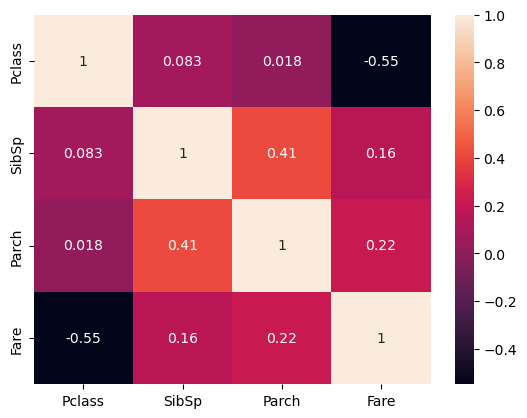

In [56]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

corr_cols = [
    "Pclass",
    # "Age", # this column has NULLs which will cause errors
             # when computing correlation matrix
    "SibSp",
    "Parch",
    "Fare"
]

corr_assembler = VectorAssembler(
    inputCols = corr_cols,
    outputCol = "features"
)

cor_mat = Correlation.corr(corr_assembler.transform(df), column = "features")

cor_mat = cor_mat.collect()[0]["pearson(features)"].toArray().tolist()

cor_mat = pd.DataFrame(cor_mat, columns = corr_cols, index = corr_cols)

sns.heatmap(cor_mat, annot = True)

<br>

---

<br>

## 5.3 NULL Values

Recall that 177 rows were missing an `Age` column. For the purposes of inference, we will likely have to drop these columns. But before dropping NULLs, we should always take a look at the rows where they exist to see if there are any patterns.

In [76]:
df.filter( df["Age"].isNull()).show()

+-----------+--------+------+--------------------+------+----+-----+-----+---------------+--------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|         Ticket|    Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+---------------+--------+-----+--------+
|          6|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0|         330877|  8.4583| NULL|       Q|
|         18|       1|     2|Williams, Mr. Cha...|  male|NULL|    0|    0|         244373|    13.0| NULL|       S|
|         20|       1|     3|Masselmani, Mrs. ...|female|NULL|    0|    0|           2649|   7.225| NULL|       C|
|         27|       0|     3|Emir, Mr. Farred ...|  male|NULL|    0|    0|           2631|   7.225| NULL|       C|
|         29|       1|     3|"O'Dwyer, Miss. E...|female|NULL|    0|    0|         330959|  7.8792| NULL|       Q|
|         30|       0|     3| Todoroff, Mr. Lalio|  male|NULL|    0|    0|      

In [78]:
df.filter( df["Age"].isNull()).groupBy("Sex").pivot("Survived").count().show()

+------+---+---+
|   Sex|  0|  1|
+------+---+---+
|female| 17| 36|
|  male|108| 16|
+------+---+---+



The subset where `Age` is NULL generally follows the same patterns as the wider population. There doesn't seem to be a discernable correlation between the other variables and a null `Age`. We can probably drop the NULL rows for now.

In [81]:
df_cleaned = df.na.drop(subset = ["Age", "Embarked"])

<br>

---

<br>

## 5.3 Categorical Predictors

In order to use categorical variables as predictors, we need to one-hot encode them into dummy variables. To do this, we need to use the `StringIndexer` and `OneHotEncoder` feature transformers. The `StringIndexer` will index each value of a categorical column with an integer (analogous to a *factor* in the R language).

Note that both of `StringIndexer` and `OneHotEncoder` come with a `fit()` method that "compiles" the steps of the transformation, and a `transform()` method that actually transforms the dataframe.

In [171]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

sex_indexer = StringIndexer(
    inputCol = "Sex",       # column to hash to integers
    outputCol = "SexIndex", # name of the resulting column
    stringOrderType = "alphabetAsc" # controls how the hashing occurs
                                    # default is to order by most frequent value;
                                    # for our purposes, we want to put 'female' at index 0
)

embark_indexer = StringIndexer(
    inputCol = "Embarked", 
    outputCol = "EmbarkedIndex"
)

# one-hot encode Pclass;
# even though Pclass is technically an ordinal variable,
# the values 1, 2, 3 do not represent a linear relationship.
# That is: 1st class is "better" than 2nd class, but this difference
# can't be objectively measured with a subtraction.
class_indexer = StringIndexer(
    inputCol = "Pclass", 
    outputCol = "PclassIndex",
    stringOrderType = "alphabetAsc"
)
onehot_encoder = OneHotEncoder(inputCols = ["SexIndex", "EmbarkedIndex", "PclassIndex"], outputCols = ["SexVec", "EmbarkedVec", "PclassVec"])

feature_cols = [
    "Age",
    "SibSp",
    "Parch",
    "Fare",
    "SexVec",
    "EmbarkedVec",
    "PclassVec"
]

assembler = VectorAssembler(inputCols = feature_cols, outputCol = "features")

For `StringIndexer` objects, the `fit()` method will transform the data and return a `StringIndexerModel` object. This object comes with a `labels` attribute which allows us to see exactly how the categories got hashed.

In [172]:
print( sex_indexer.fit(df_cleaned).labels )
print( embark_indexer.fit(df_cleaned).labels )
print( class_indexer.fit(df_cleaned).labels )

['female', 'male']
['S', 'C', 'Q']
['1', '2', '3']


In [173]:
df_temp = sex_indexer.fit(df_cleaned).transform(df_cleaned)

df_temp = embark_indexer.fit(df_temp).transform(df_temp)

df_temp = class_indexer.fit(df_temp).transform(df_temp)

df_temp.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+-------------+-----------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|SexIndex|EmbarkedIndex|PclassIndex|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+-------------+-----------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|     1.0|          0.0|        2.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|     0.0|          1.0|        0.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|     0.0|          0.0|        2.0|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| 

For the `Sex` column, the value of `female` got hashed to 0 while `male` was hashed to 1. Similarly for the `Embarked` column, `S` was hashed to 0, `C` to 1, and `Q` to 2. By default, `OneHotEncoder` objects will drop the last index of the category when creating dummy variables (to prevent perfect multicollinearity). This means that modeling dataframe will contain:

* A dummy variable for the `female` category, indicating if the person was `female` or not. The `male` category gets dropped.
* A dummy variable for the `S` category, indicating if the person embarked at `Southhampton`.
* A dummy variable for the `C` category, indicating if the person embarked at `Cherbourg`. The `Q` category gets dropped

In [174]:
print(f"Category Sizes: {onehot_encoder.fit(df_temp).categorySizes}")
onehot_encoder.fit(df_temp).transform(df_temp).show()

Category Sizes: [2, 3, 3]
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+-------------+-----------+-------------+-------------+-------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|SexIndex|EmbarkedIndex|PclassIndex|       SexVec|  EmbarkedVec|    PclassVec|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+-------------+-----------+-------------+-------------+-------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|     1.0|          0.0|        2.0|    (1,[],[])|(2,[0],[1.0])|    (2,[],[])|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|     0.0|          1.0|        0.0|(1,[0],[1.0])|(2,[1],[1.0])|(2,[0],[1.0])|
|          3| 

<br>

---

<br>

## 5.4 Pipelines

Notice that there are quite a few transformations the data set must undergo:

* The `Sex` column has to be transformed into an integer column of indices called `SexIndex`
* The `SexIndex` column has to be one-hot encoded into a column of vectors called `SexVec`
* The `Embarked` column has to be transformed into an integer column of indices called `EmbarkedIndex`
* The `EmbarkedIndex` column has to be one-hot encoded into a column of vectors called `EmbarkedVec`
* All the features have to be assembled into a single column called `features`.

After all of these transformations are complete, we then have to fit a model on the transformed dataframe. Ideally, all of these steps could be packaged together into a single callable object and that is exactly what the `Pipeline` object does for us.

Note: since we want to do inference, we will want to estimate the standard errors and p-values of the coefficients in our logistic regression. The `LogisticRegression` estimator doesn't come with this data. Instead, we need to use the `GeneralizedLinearRegression` estimator and pass in the appropriate `family` and `link` arguments. 

In [175]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GeneralizedLinearRegression

logreg_estimator = GeneralizedLinearRegression(
    featuresCol = "features", 
    labelCol = "Survived",
    family = "binomial",
    link = "logit"
)

# build pipeline object;
# we do this by passing a list
# of transfomers
logreg_pipeline = Pipeline(
    stages = [
        sex_indexer, 
        embark_indexer,
        class_indexer,
        onehot_encoder,
        assembler,
        logreg_estimator
    ]
)

# fit model
logreg_model = logreg_pipeline.fit(df_cleaned)

# get model summary; 
# Note that PipelineModel objects do not have a summary attribute
# so we have to go to the last stage (the LogisticRegressionModel)
# to extract the summary attribute
logreg_summary = logreg_model.stages[-1].summary
logreg_coef = logreg_model.stages[-1].coefficients

In [185]:
colnames = [
    "Age",
    "SibSp",
    "Parch",
    "Fare",
    "is_female",
    "is_southhampton",
    "is_cherbourg",
    "is_1st_class",
    "is_2nd_class"
]

for result in zip(colnames, logreg_model.stages[-1].coefficients, logreg_summary.pValues):
    sig_code = ""
    if result[2] < 0.01:
        sig_code = "(***)"
    elif result[2] < 0.05:
        sig_code = "(**)"
    elif result[2] < 0.1:
        sig_code = "(*)"
    print(f"{result[0]} {sig_code}: {result[1]} , p-value: {result[2]}")

Age (***): -0.043308465603244105 , p-value: 1.951227168728309e-07
SibSp (***): -0.3629251992803568 , p-value: 0.004999634327305547
Parch : -0.06036514250004655 , p-value: 0.6262326224247166
Fare : 0.0014505840827550136 , p-value: 0.5761433962634026
is_female (***): 2.6378591988135813 , p-value: 0.0
is_southhampton : 0.4205318397276761 , p-value: 0.4497407222571197
is_cherbourg : 0.823379451022296 , p-value: 0.17011265082109706
is_1st_class (***): 2.3952198819466455 , p-value: 3.0393465522138285e-12
is_2nd_class (***): 1.20558268971725 , p-value: 1.3859160119533698e-06


On average, the model is saying:

* `Age` has a slight negative relationship with survival probability: younger people were slightly more likely to survive. This is likely causal since younger children were given priority on the lifeboats.
* `SibSp` has a negative relationship with survival probability; it's not clear if this relationship is legitimate or spurious, since we do not have any a priori reason to believe that having more siblings / being married would decrease survival probability.
* `is_female` has a strong positive relationship with survival probability. This is almost certainly causal since women, specifically mothers, were likely given priority on the lifeboats.
* `is_1st_class` and `is_2nd_class` both have a strong positive relationship with survival probability. This is almost certainly causal since it's likely that more affluent passengers were shown preferential treatment.

The remaining 4 variables: `Parch`, `Fare`, `is_southhampton`, and `is_cherbourgh` were not statistically significant. The `Parch` variable is likely measuring the same information as `is_female` and `Age`, while `Fare` is likely measuring the same information as `is_1st_class` and `is_2nd_class`. The embark locations are likely colinear with class and sex, so it does not give any new information here.

<br>

---

<br>